# Session 8: Staging and Preprocessing

In [ ]:
# import all the libraries we need
import logging
import os
from datetime import datetime
import inspect
import random

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import box
from pdgstaging import TileStager

# For parallel processing
import parsl
from parsl import python_app
from parsl.config import Config
from parsl.channels import LocalChannel
from parsl.executors import HighThroughputExecutor
from parsl.providers import LocalProvider

# set up plotting in notebook
plt.style.use('seaborn-notebook')
font_size = 4
plt.rcParams['font.size'] = font_size
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size
plt.rcParams['xtick.labelsize'] = font_size
plt.rcParams['ytick.labelsize'] = font_size
plt.rcParams['legend.fontsize'] = font_size
plt.rcParams['figure.titlesize'] = font_size
plt.rcParams['figure.dpi'] = 200

## Background

### The `TileStager` class

The `TileStager` is a class from the pdgstaging library. The purpose of the
`TileStager` is to "stage" the input vector data. We are using the term "stage"
to encompass *all* of the following tasks:

- simplify the polygons (optional)
- set an input CRS if one is missing in the input data (optional)
- reproject the data to the CRS of the TMS, when required
- add additional properties to each polygon, including: the centroid x and y
  coordinates, the area, a unique ID, and the name of the file that the
  polygon originated from
- Most importantly: break each input file into [standardized tiles](https://docs.opengeospatial.org/is/17-083r2/17-083r2.html), and save
 them to disk.
- (Staging also currently removes any geometries that are not polygons. Even
  multipolygons are removed. Subsequent processing is set up for only polygons
  at the moment, something we need to adapt in the future)

![](https://raw.githubusercontent.com/PermafrostDiscoveryGateway/viz-staging/develop/docs/images/staging_tldr.png)

There are two key methods available in the `TileStager`: `stage` and `stage_all`

#### The `TileStager.stage` method

The `stage` method does all of the tasks listed above for a single input vector file.

In [ ]:
help(TileStager.stage)

In [ ]:
# The stage method just combines 5 different steps into one function.
print(inspect.getsource(TileStager.stage))

#### The `TileStager.stage_all` method

The `stage_all` method just calls the stage method for every input file.

In [ ]:
help(TileStager.stage_all)

In [ ]:
print(inspect.getsource(TileStager.stage_all))

### Configuration & Tiles

The `stage` method only requires a `path` argument, and the `stage_all` method requires no arguments at all. This is because all options are set when we instantiate the `TileStager` class. 

In [ ]:
# Set some options for tiling
iwp_config = {
    # The directory and file type of the input vector data the we want to stage
    'dir_input': 'example-data',
    'ext_input': '.gpkg',
    # The path to the directory where we want the output tiles to be saved
    # (this will be created if it doesn't exist)
    'dir_staged': 'staged',
    # Set simplify_tolerance to None to disable polygon simplification (not needed)
    'simplify_tolerance': None
}

# Create an instance of the TileStager class, which we can use to 
iwp_stager = TileStager(iwp_config)

Once instantiated, The TileStager class contains an instance of a `pdgstaging.ConfigManager` class, and a `pdgstaging.TilePathManager` class.

An instance of the ConfigManager class is stored as the `config` attribute of the TileStager. The documentation for the ConfigManager gives details about all the configuration options that can be set.

In [ ]:
help(iwp_stager.config)

In [ ]:
# To see the default configuration options, use:
iwp_stager.config.defaults

Information about the TMS (Tile Matrix Set) we will use, and methods dealing with paths and tiles are managed using an instance of the `TilePathManager` class, available in the stager as the `tiles` attribute.

In [ ]:
help(iwp_stager.tiles)

## The Data

In [ ]:
# Here is a list of all the files we want to stage:
files_to_stage = iwp_stager.tiles.get_filenames_from_dir('input')
num_files_to_stage = len(files_to_stage)
file_sizes = [os.path.getsize(f) for f in files_to_stage]
size_files_to_stage = round(sum(file_sizes) / 1024 / 1024 / 1024, 2)
min_file_size = round(min(file_sizes) / 1024 / 1024 / 1024, 2)
max_file_size = round(max(file_sizes) / 1024 / 1024 / 1024, 2)
print(f'There are {num_files_to_stage} vector files to stage, totalling {size_files_to_stage} GB.'
        f'\nThe smallest file is {min_file_size} GB, and the largest file is {max_file_size} GB.')

In [ ]:
# Reading in and plotting just one of these files is slow
example_file = files_to_stage[0]
start_time = datetime.now()
gdf = gpd.read_file(example_file)
gdf.plot()
plt.tight_layout()
plt.show()
num_polygons = len(gdf.geometry)
end_time = datetime.now()
total_time = round((end_time - start_time).total_seconds(), 1)
print(f'It took {total_time} seconds to read in and plot the'
      f' first file, with {num_polygons} polygons.')

## Staging one file

In [ ]:
# We can stage just one file with the stage method
start_time = datetime.now()
iwp_stager.stage(example_file)
end_time = datetime.now()
total_time = round((end_time - start_time).total_seconds(), 2)
staged_files = iwp_stager.tiles.get_filenames_from_dir('staged')
print(f'It took {total_time} seconds to stage the first file,'
        f' resulting in {len(staged_files)} tiled vector files.')

In [ ]:
# Lets plot each of the new vector tiles we just created. Each with a different color.
# We can use the get_filenames_from_dir method to get a list of all the files we just staged.
def random_hex_color():
    return '#%06x' % random.randint(0, 0xFFFFFF)

ax = None
for tile in staged_files:
    gdf = gpd.read_file(tile)
    if ax is None:
        ax = gdf.plot(color=random_hex_color())
    else:
        gdf.plot(ax=ax, color=random_hex_color())

plt.show()

In [ ]:
# We can roughly guess how long it would take to stage all the files consecutively with the stage_all.method
est_time_all_files = round((total_time * num_files_to_stage) / 60, 1)
print(f'It would take about {est_time_all_files} minutes to stage all {num_files_to_stage} files consecutively.')

In [ ]:
# Instead, we can stage all the files in parallel.
# First, remove the files we already have staged, including the CSV file that summarizes the staging process.
# (otherwise, the same polygons will be appended to the file when we stage it again)
os.system(f'rm -rf {iwp_stager.config.get("dir_staged")}')
os.system(f'rm {iwp_stager.config.get("filename_staging_summary")}')

## Stage all the input files in parallel

In [ ]:
# Set up Parsl
# TODO: Jeanette - not sure how to set up Parsl for the course. This is what I'm using on the datateam server...
activate_conda = 'source /home/sjclark/miniconda3/bin/activate scale_comp'
htex_local = Config(
    executors=[
        HighThroughputExecutor(
            label="htex_local",
            worker_debug=False,
            cores_per_worker=1,
            max_workers=26,
            provider=LocalProvider(
                channel=LocalChannel(),
                init_blocks=1,
                max_blocks=20,
                worker_init=activate_conda
            )
        )
    ],
)
parsl.clear()
parsl.load(htex_local)

In [ ]:
# Let's also set up logging so we can see what's going on
logging.basicConfig(level=logging.INFO)

In [ ]:
# Make a Parsl app that uses the stage method
@python_app
def stage_file(path, config):
    import logging
    from pdgstaging import TileStager
    logging.basicConfig(level=logging.INFO)
    stager = TileStager(config)
    stager.stage(path)
    return path

In [ ]:
start_time = datetime.now()

app_futures = []
for path in files_to_stage:
    app_future = stage_file(path, iwp_config)
    app_futures.append(app_future)

# By getting the `result()` of each app future, this block won't continue to the print statement until all the files are staged.
done = [app_future.result() for app_future in app_futures]
end_time = datetime.now()
total_minutes = round(((end_time - start_time).total_seconds() / 60), 2)
print(f'🎉🎉🎉 Finished staging {len(files_to_stage)} files in {total_minutes} minutes.')

htex_local.executors[0].shutdown()
parsl.clear()


## Plot the results

In [25]:
# It would take ages to plot all of the tiles we created, but we can plot the
# boundaries of each tile. This information is stored in the staging summary
# csv that the tiler created.
summary_path = iwp_stager.config.get("filename_staging_summary")
summary = pd.read_csv(summary_path)
summary

,filename,num_polygons,area_polygons,datetime,tile_x,tile_y,tile_z,tile_top,tile_right,tile_bottom,tile_left,tms_identifier
0,GE01_20180907225323_1050010012146100_18SEP0722...,1,2.620270e-08,2022-07-20 13:29:26.053499,909,1059,13,66.730957,-160.004883,66.708984,-160.026855,WorldCRS84Quad
1,GE01_20180907225323_1050010012146100_18SEP0722...,9,6.370861e-07,2022-07-20 13:29:26.185821,909,1060,13,66.708984,-160.004883,66.687012,-160.026855,WorldCRS84Quad
2,GE01_20180907225323_1050010012146100_18SEP0722...,19,1.208546e-06,2022-07-20 13:29:26.250953,909,1061,13,66.687012,-160.004883,66.665039,-160.026855,WorldCRS84Quad
3,GE01_20180907225323_1050010012146100_18SEP0722...,9,5.847288e-07,2022-07-20 13:29:26.300402,910,1059,13,66.730957,-159.982910,66.708984,-160.004883,WorldCRS84Quad
4,GE01_20180907225323_1050010012146100_18SEP0722...,1137,6.222961e-05,2022-07-20 13:29:27.117265,910,1060,13,66.708984,-159.982910,66.687012,-160.004883,WorldCRS84Quad
...,...,...,...,...,...,...,...,...,...,...,...,...
4094,WV02_20130820230259_1030010026486200_13AUG2023...,569,4.882045e-06,2022-07-20 13:34:45.336993,957,1054,13,66.840820,-158.950195,66.818848,-158.972168,WorldCRS84Quad
4095,WV02_20130820230259_1030010026486200_13AUG2023...,2258,2.945750e-05,2022-07-20 13:34:46.598086,957,1055,13,66.818848,-158.950195,66.796875,-158.972168,WorldCRS84Quad
4096,WV02_20130820230259_1030010026486200_13AUG2023...,8,2.634584e-07,2022-07-20 13:34:46.699960,957,1056,13,66.796875,-158.950195,66.774902,-158.972168,WorldCRS84Quad
4097,WV02_20130820230259_1030010026486200_13AUG2023...,8,1.770936e-07,2022-07-20 13:34:46.801739,958,1054,13,66.840820,-158.928223,66.818848,-158.950195,WorldCRS84Quad


In [26]:
tile_summary = summary.groupby(['tile_x','tile_y', 'tile_z'], as_index=False).agg({
    # the total number and area of polygons in each tile
    'num_polygons':'sum',
    'area_polygons':'sum',
    # the count of source files that contributed polygons to each tile
    'filename': 'nunique',
    # tile boundaries will all be the same, so we can just take the first one
    'tile_top': 'first',
    'tile_left': 'first',
    'tile_bottom': 'first',
    'tile_right': 'first'
})
def tile_row_to_geom(row):
    return box(minx=row['tile_left'], miny=row['tile_bottom'], maxx=row['tile_right'], maxy=row['tile_top'])
tile_summary['geometry'] = tile_summary.apply(tile_row_to_geom, axis=1)
tile_summary.drop(['tile_top', 'tile_left', 'tile_bottom', 'tile_right'], axis=1, inplace=True)
tile_summary_gdf = gpd.GeoDataFrame(tile_summary)
tile_summary_gdf

,tile_x,tile_y,tile_z,num_polygons,area_polygons,filename,geometry
0,891,1052,13,11,3.269851e-07,1,"POLYGON ((-160.40039 66.86279, -160.40039 66.8..."
1,892,1051,13,5,1.350973e-07,1,"POLYGON ((-160.37842 66.88477, -160.37842 66.9..."
2,892,1052,13,1069,2.997467e-05,1,"POLYGON ((-160.37842 66.86279, -160.37842 66.8..."
3,892,1053,13,312,1.154277e-05,1,"POLYGON ((-160.37842 66.84082, -160.37842 66.8..."
4,892,1054,13,624,1.945030e-05,1,"POLYGON ((-160.37842 66.81885, -160.37842 66.8..."
...,...,...,...,...,...,...,...
2244,966,1082,13,501,9.348094e-06,1,"POLYGON ((-158.75244 66.20361, -158.75244 66.2..."
2245,966,1083,13,502,9.521898e-06,1,"POLYGON ((-158.75244 66.18164, -158.75244 66.2..."
2246,966,1084,13,147,3.556369e-06,1,"POLYGON ((-158.75244 66.15967, -158.75244 66.1..."
2247,967,1078,13,92,2.272667e-06,1,"POLYGON ((-158.73047 66.29150, -158.73047 66.3..."


<AxesSubplot:>

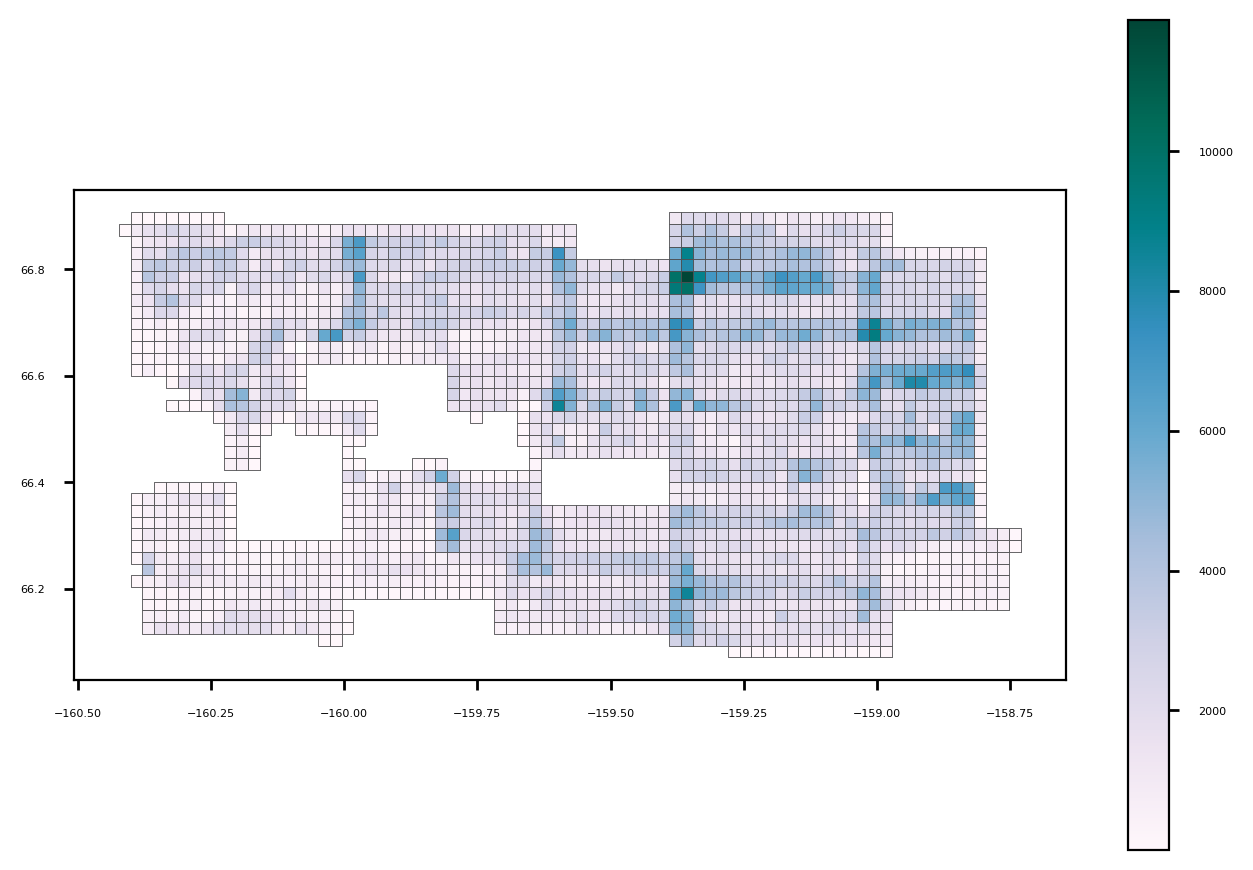

In [27]:
# Number of polygons per tile
tile_summary_gdf.plot(column='num_polygons', cmap='PuBuGn', edgecolor='#4d4d4f', legend=True)

<AxesSubplot:>

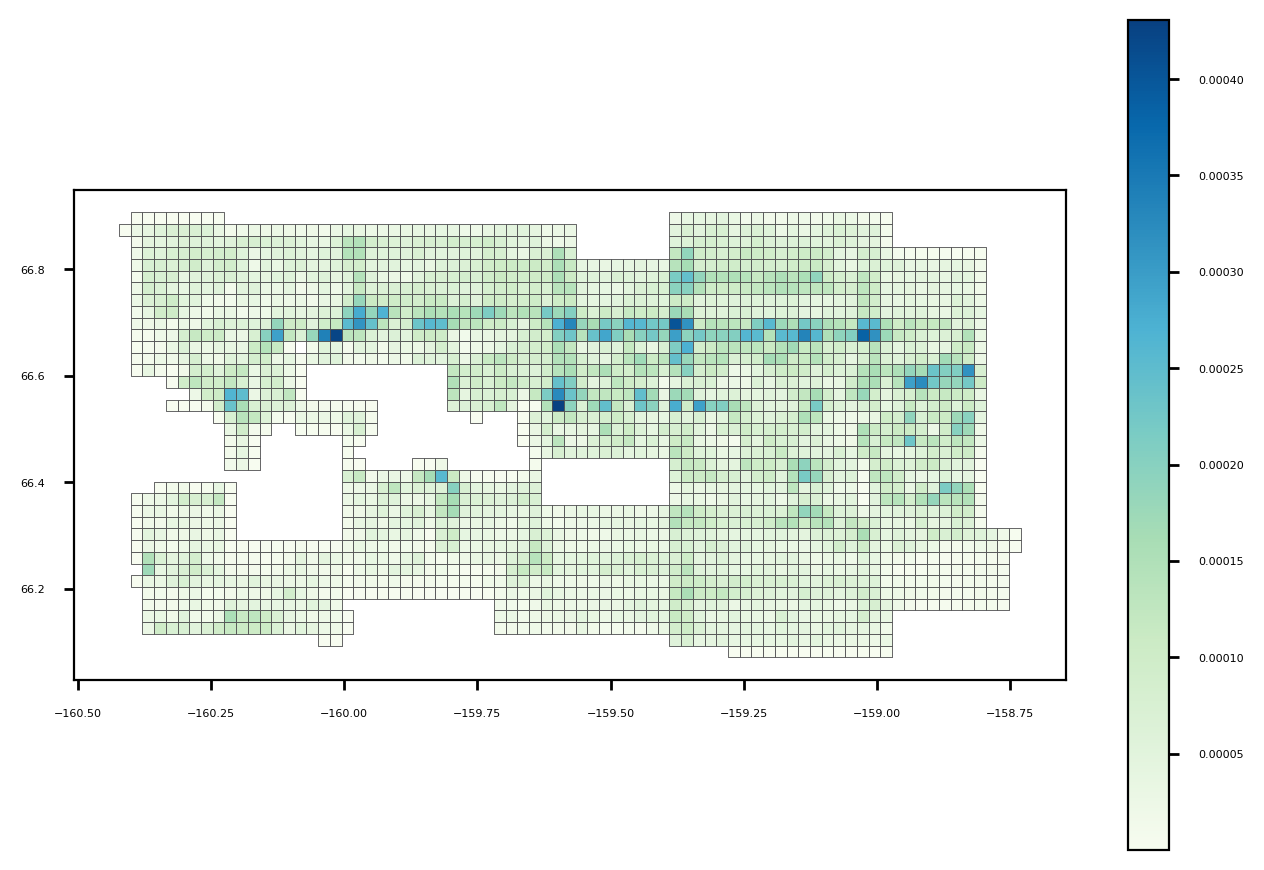

In [28]:
# Area of each tile covered by polygons
tile_summary_gdf.plot(column='area_polygons', cmap='GnBu', edgecolor='#4d4d4f', legend=True)

<AxesSubplot:>

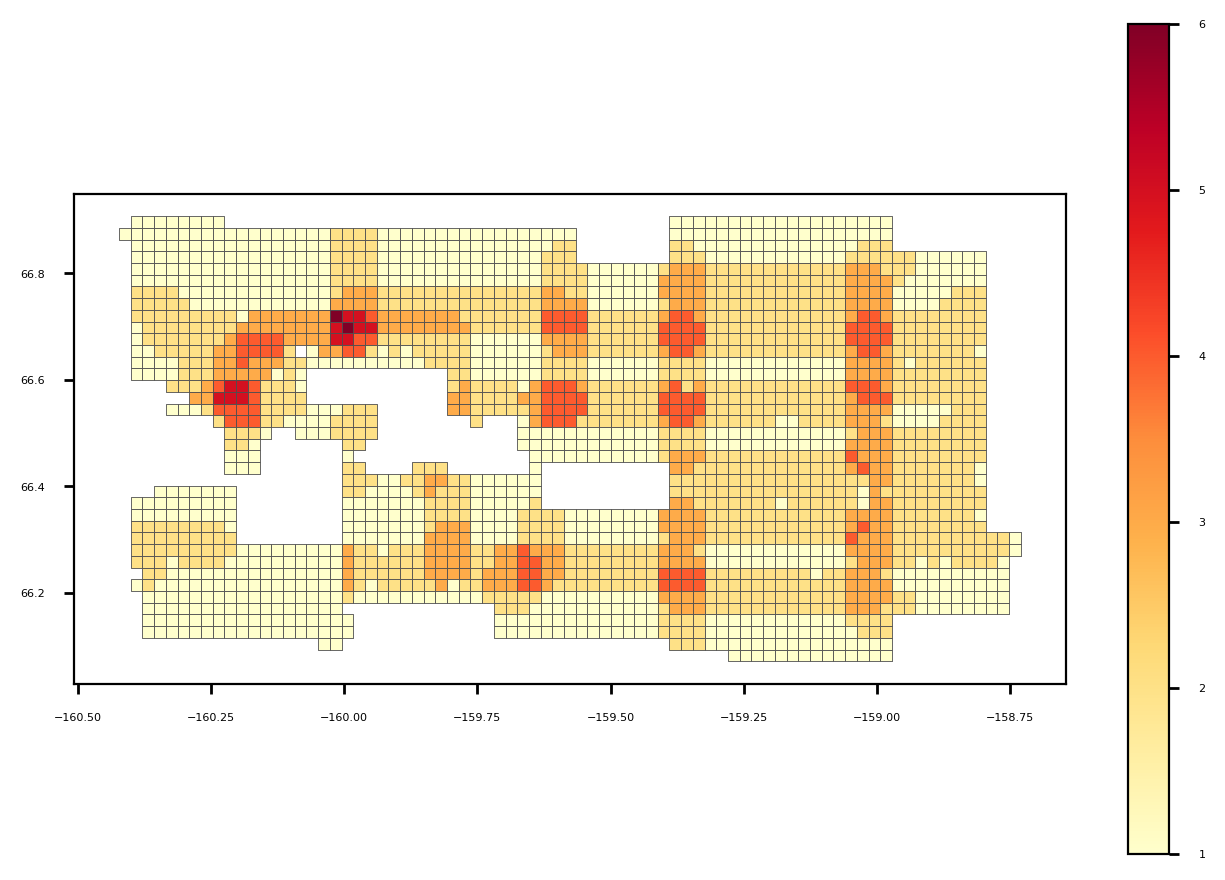

In [29]:
# Number of source files per tile
tile_summary_gdf.plot(column='filename', cmap='YlOrRd', edgecolor='#4d4d4f', legend=True)

# See Also:
- [pdgstaging GitHub README](https://github.com/PermafrostDiscoveryGateway/viz-staging/tree/develop) - detailed overview
- [more documentation](https://github.com/PermafrostDiscoveryGateway/viz-staging/blob/develop/docs/_index.md)